In [4]:
import numpy as np
import matplotlib.pyplot as plt
from bandits_utils import *
import pandas as pd

## Work with dataframe

In [6]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', 
                        names = ['UserID', 'MovieID', 'Rating', 'Timestamp'],
                        encoding = 'latin1',
                        engine = 'python')
movies  = pd.read_csv('ml-1m/movies.dat',  sep='::',
                        names = ['MovieID', 'Title', 'Genres'], 
                        encoding = 'latin1',
                        engine ='python')
users   = pd.read_csv('ml-1m/users.dat',  sep='::', 
                        names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip'], 
                        encoding = 'latin1',
                        engine = 'python')

In [7]:
N = 1000
ratings_count = ratings.groupby(by='MovieID', as_index=True).size()
# top_ratings = ratings_count.sort_values(ascending=False)[:N]
top_ratings = ratings_count[ratings_count>=N]
top_ratings.head(10)

MovieID
1      2077
11     1033
21     1356
32     1511
34     1751
39     1362
47     1137
50     1783
110    2443
111    1240
dtype: int64

In [8]:
movies_topN = movies[movies.MovieID.isin(top_ratings.index)]
# print('Shape: {}'.format(movies_topN.shape))
# movies_topN
ratings_topN = ratings[ratings.MovieID.isin(top_ratings.index)]
print('Shape: {}'.format(ratings_topN.shape))
ratings_topN.head(10)

Shape: (305373, 4)


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
7,1,2804,5,978300719
9,1,919,4,978301368
10,1,595,5,978824268
13,1,2918,4,978302124
15,1,2791,4,978302188
19,1,2797,4,978302039


In [9]:
n_users = ratings_topN.UserID.unique().shape[0]
n_movies = ratings_topN.MovieID.unique().shape[0]
print('Number of users = {} | Number of movies = {}'.format(n_users, n_movies))

Number of users = 6039 | Number of movies = 207


In [10]:
R_df = ratings_topN.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R = np.array(R_df)

### Work with generated matrix

In [67]:
def generate_matrix(n_users, n_movies, prob) :
    # We fill in the matrix with a non-null value with probability prob to obtain a scarce matrix
    Ratings = []
    for i in range(n_users*n_movies):
        if np.random.random()>prob :
            Ratings.append(0)
        else : 
            Ratings.append(np.random.randint(1,6))
    Ratings = np.array(Ratings).reshape((n_users,n_movies))
    return Ratings

In [68]:
R = generate_matrix(30,60,0.6)
R

array([[5, 2, 4, ..., 0, 1, 3],
       [1, 0, 0, ..., 0, 1, 0],
       [5, 1, 2, ..., 1, 4, 0],
       ...,
       [1, 0, 5, ..., 1, 5, 0],
       [5, 0, 2, ..., 2, 3, 5],
       [3, 4, 2, ..., 4, 0, 0]])

$$R \sim U \cdot M$$

In [11]:
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF

def fill_matrix_MF(ratings, d, max_iter = 1000):
    """
    Returns a predicted matrix using matrix factorization to deal with zeros(non rated movies)
    """

    model = NMF(n_components=d, init='random', random_state=0, max_iter = max_iter)

    U = model.fit_transform(R)
    M = model.components_

    return U@M

In [12]:
fill_matrix_MF(R,3)

array([[0.99895209, 0.57589131, 0.5928224 , ..., 0.45806756, 0.38231285,
        0.45297197],
       [1.64036718, 0.87907152, 1.05393844, ..., 0.93915027, 0.71838486,
        1.26010558],
       [0.78432038, 0.29891384, 0.53085729, ..., 0.36453973, 0.27038005,
        0.57428076],
       ...,
       [0.14842544, 0.04905585, 0.09905826, ..., 0.05286373, 0.04054158,
        0.08210168],
       [0.53104224, 0.0823015 , 0.35333527, ..., 0.04699657, 0.04564213,
        0.09598709],
       [2.03091306, 0.72702888, 1.27177478, ..., 0.50908593, 0.44656117,
        0.55954077]])

In [71]:
user = R[-1]
R = R[:-1]
print(R)

[[5 2 4 ... 0 1 3]
 [1 0 0 ... 0 1 0]
 [5 1 2 ... 1 4 0]
 ...
 [0 4 0 ... 0 3 0]
 [1 0 5 ... 1 5 0]
 [5 0 2 ... 2 3 5]]


## Finding out clusters in our matrix

Text(0.5, 1.0, 'Elbow curve')

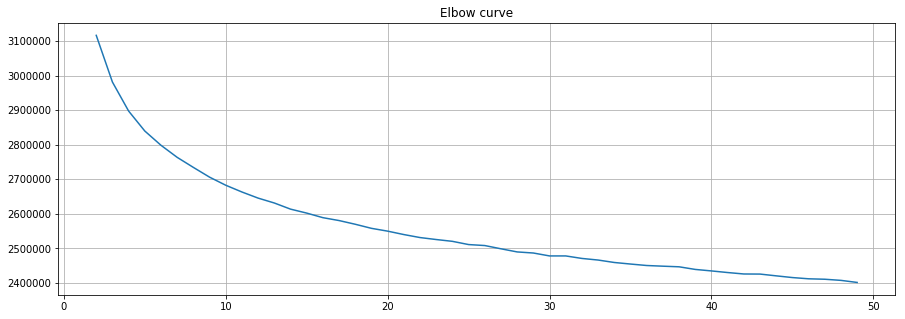

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distorsions = []
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 50), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5, 1.0, 'Elbow curve')

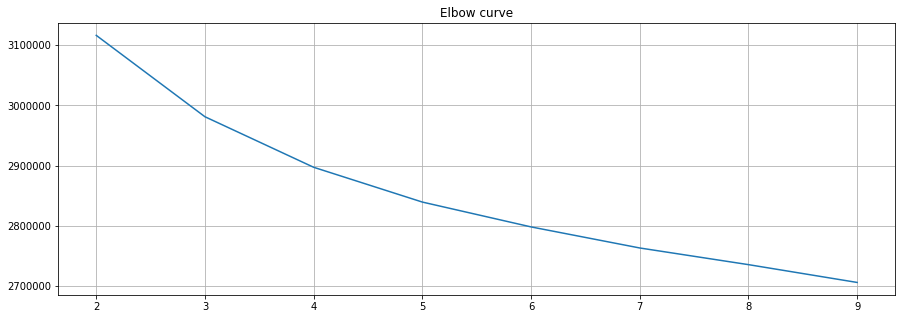

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(R)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [17]:
#Choose number of clusters
nb_clusters = 7
labels = KMeans(nb_clusters).fit(R).labels_
print(labels)
clusters_rating_mean = [R]

[2 0 2 ... 2 6 3]


## Clusters_rating_mean is a matrix of size (M movies x C clusters), in each column there is the mean rating of the cluster

In [18]:
clusters_rating_mean = R.T@np.eye(nb_clusters)[labels]
for i in range(nb_clusters):
    clusters_rating_mean[:,i] = clusters_rating_mean[:,i]/np.count_nonzero(labels == i)

In [19]:
best_movies_by_cluster = np.argsort(-1*clusters_rating_mean, axis=0)

In [20]:
best_movies_by_cluster[:,1]

array([ 63,  12,  65, 154,  69,  29,  80,  24,  90,   8, 111,  64, 135,
        52,  87, 174, 157,  23,  66,  40,  71, 114, 131,  17,  31,  98,
        60,   0,  58,  37, 108,  21, 167,  32, 197, 166, 198,  22, 150,
       139,  94,  36, 172, 101,  14, 110,  26,  86,  41,  99, 178, 158,
        73,  15,  96, 126,  59,  75,  16, 206, 179, 185, 113,  97, 189,
        25, 132, 140,  13,  35, 147, 112, 120, 182, 170, 156, 128,  61,
       109, 141,  85, 149, 175, 153,  30, 115, 133, 134,   7,  53,  46,
        93,  74,   3,  38, 169, 105,  28,  81,   2, 130, 201, 202,  49,
       100,  92, 195, 168,  20, 199, 194, 162,  54, 127, 102,  19, 137,
        27,  33, 192, 125, 204, 180, 136, 151,   4, 107, 117, 123, 177,
        10, 138,   6, 171, 152,  11, 183, 164,  56, 103,  88, 188, 163,
       104, 122,  67,  39, 187, 193, 159, 176, 160,  70, 143, 142, 129,
        55, 203,  78, 200,   5,  34, 106,  51, 190,  91,  18,   1, 145,
       116,  84, 124, 144,  79, 205,  68,  44,  72, 181,  50, 19

In [22]:
def get_reward(movie, user) :
    return user[movie]

In [23]:
def UCB(cluster_index, delta, new_user, mu, T):
    if T[cluster_index] == 0:
        return 100000
    else:
        return mu[cluster_index] + np.sqrt(2 * np.log(1/delta)/T[cluster_index])

In [34]:
def UCB_tot(n, new_user, delta, best_movies_by_cluster, k):
    X = np.zeros(n) ##Réalisations (X_t)_t
    T = np.zeros(k, dtype = int) ##T[i] = nb de fois où i a été tiré
    arms_mat = np.zeros((n,k))
    mu = np.zeros(k) ##mu[i] = moyenne empirique de i

    A = np.zeros(n, dtype = int)
    
    for t in range(n):
        all_A_t = np.zeros(k)
        for i in range(k):
            all_A_t[i] = UCB(i, delta, new_user, mu, T) ##On calcul UCB_i pour tous les bras
        A[t] = np.argmax(all_A_t) ##On prend le bras qui a le UCB_i le plus haut
        movie = best_movies_by_cluster[:,A[t]][T[A[t]]]
        X[t] = get_reward(movie,new_user) ##On génère X_t la réalisation à partir du bras choisi
        T[A[t]] += 1 ##Le bras i a été tiré une fois de plus
        arms_mat[t, A[t]] = X[t] ##On stock la valeur de la réalisation dans une matrice
        mu[A[t]] = 1/T[A[t]] * sum(arms_mat[:, A[t]]) ##On update la moyenne empirique
#         Rn[t] = (t+1)*mu_star - T@mu ##On calcul le regret à l'instant t
    return X, A, T, mu

In [ ]:
# We take the new user to be a mean between two users of cluster 0 for instance
new_user = np.mean(R[labels==0][:3],axis=0)

In [35]:
n = 100
delta = 1/(n**2)

X_t, arms, T, mu= UCB_tot(n, new_user, delta, best_movies_by_cluster, nb_clusters)

print(arms)
print(mu)

[0 1 2 3 4 5 6 0 2 6 3 0 1 2 2 6 0 0 0 0 2 3 2 2 2 6 2 0 0 0 0 0 4 5 2 0 0
 2 0 1 4 4 4 4 5 0 0 4 2 0 2 0 0 6 6 1 1 1 1 1 1 3 3 3 3 3 3 5 5 5 5 5 5 5
 5 5 5 0 6 0 0 2 0 5 2 2 2 3 3 4 4 0 0 0 2 0 1 1 1 5]
[2.44047619 1.88888889 2.12962963 1.81818182 1.7037037  1.97777778
 1.47619048]


* We notice that cluster 0 is the one that has the best rating which is good since the new user is a combination of users of cluster 0 *

In [43]:
# We take the new user to be a mean between two users of cluster 0 for instance
new_user = (4*np.mean(R[labels==3][:4],axis=0) + 2*np.mean(R[labels==0][:2],axis=0))/6

In [44]:
n = 200
delta = 1/(n**2)

X_t, arms, T, mu= UCB_tot(n, new_user, delta, best_movies_by_cluster, nb_clusters)

print(arms)
print(T)
print(mu)

[0 1 2 3 4 5 6 0 2 6 3 1 4 5 0 6 2 3 0 1 4 5 1 3 5 3 6 2 0 0 4 0 3 1 5 5 6
 6 3 3 5 3 4 1 2 0 6 5 5 0 5 3 3 6 6 6 6 6 2 1 0 4 6 3 5 6 0 3 3 2 5 1 6 6
 4 5 0 6 3 2 2 1 6 3 6 1 0 2 4 6 0 5 3 1 5 4 6 6 3 0 3 3 2 5 5 0 3 2 6 1 5
 6 5 5 3 4 0 0 5 3 2 2 6 3 1 5 3 6 6 6 0 5 1 5 3 3 4 4 4 6 0 3 5 4 2 2 2 3
 3 3 6 3 3 3 5 2 2 0 6 6 5 3 1 4 2 2 0 6 1 5 3 0 0 5 3 3 6 3 1 4 3 6 5 6 2
 2 3 0 5 6 3 1 4 3 5 6 6 6 0 0]
[27 18 23 43 17 32 40]
[2.35802469 2.14814815 2.3115942  2.57364341 2.11764706 2.41666667
 2.50833333]


* Here, we notice that cluster 3 is the one with the highest rating and it's reasonable since the new user is 'more of a cluster 3 person than of a cluster 0' *